In [534]:
from ml_model import nn
from numerical_model import lorenz96

import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Avg Error across 40 components')

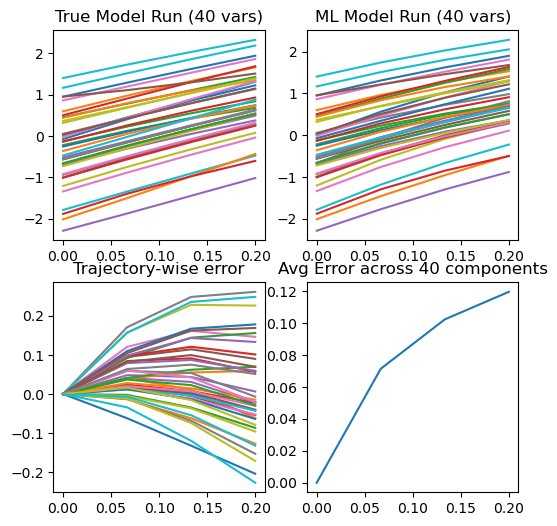

In [535]:
# Time step for the ML model; use the same for the numerical integration
# total time 
t_tot = .2
n_steps = 4
dt = t_tot / n_steps

# Generate a random state
np.random.seed(270)
x0 = np.random.randn(40)

x = x0
x_ml = np.zeros((n_steps, 40))
x_ml[0] = x0
for i in range(1, n_steps):
    x = nn._smodel.predict(x.reshape((1, 40, 1)))[0, :, 0]
    x_ml[i] = x

x_phys = solve_ivp(lorenz96, [0, n_steps*dt], x0, t_eval=np.arange(0.0, n_steps*dt, dt)).y.T

time = np.linspace(0, dt * n_steps, x_phys.shape[0])
# plot physical trajectory, nn trajectory and error with time on the x-axis
fig, ax = plt.subplots(2,2, figsize=(6,6))
ax[0,0].plot(time, x_phys)
ax[0,0].set_title("True Model Run (40 vars)")
ax[0,1].plot(time, x_ml)
ax[0,1].set_title("ML Model Run (40 vars)")
ax[1,0].plot(time, x_ml-x_phys)
ax[1,0].set_title("Trajectory-wise error")

ax[1,1].plot(time, np.sqrt(((x_ml - x_phys)**2).mean(axis=1)))
ax[1,1].set_title("Avg Error across 40 components")


In [536]:
y = x_phys[-1,:] # extract values we want to fit with EKI

## Notation
The `Lorenz96` model, named after it's founder, Ed Lorenz, in 1996, is a dynamical system that mimics the state of the atmosphere at 40 equally spaced points around a latitude band. For the earth, the high rotation rate and thin atmosphere result in a system where the dominant direction of motion is East-West, not North-South, and thus the one-dimensional approximation is perhaps to first order somewhat reasonable.  Examining the 40 ordinary differential equations, 
$$ \frac{dx_i}{dt} = (x_{i+1}- x_{i-2})\cdot x_{i-1} - x_i + F$$ 
We see three terms added together. The first is an asymetric interaction term that evolves the state at the current location based on its neighbors; this models the advective dynamics of the atmosphere, while the other two terms, $-x_i$ and $F$ correspond to forcing term. Here we can imagine that $-x_i$ is a dissipation term, e.g., outgoing longwave radiation, while $+F$, is forcing, e.g., solar insolation, that is added to the system. The value $F=8$ is used in our project because it has been shown to generate chaotic behavior.

### Motivation 
Let's see if we can solve this with backwards euler!?

In [651]:
def lorenz96(t, x, F=8):
    """Lorenz 96 model with constant forcing"""
    N = len(x)
    dxdt = np.zeros(N)
    for i in range(N):
        dxdt[i] = (x[(i + 1) % N] - x[i - 2]) * x[i - 1] - x[i] + F
    return dxdt

def integrate_backward_euler(lorenz_func, t_span, x0, F=8, dt=0.00001):
    """Integrate the given function backwards in time using Euler steps"""
    t_points = np.arange(t_span[0], t_span[1], -dt)
    n_steps = len(t_points)
    n_dim = len(x0)
    x = np.zeros((n_steps, n_dim))
    x[0] = x0
    
    for i in range(1, n_steps):
        dxdt = lorenz_func(t_points[i], x[i - 1], F)
        x[i] = x[i - 1] - dxdt * dt
        
    return t_points, x

# Define parameters
t_span = [0, -.200001]  # Integrate backwards in time 

# Integrate backwards in time using Euler steps
t_points, x = integrate_backward_euler(lorenz96, t_span, y+np.random.randn(40)*1)

print("Integration successful.")
print("Time points:", t_points)
print("Solution shape:", x.shape)


Integration successful.
Time points: [ 0.0000e+00 -1.0000e-05 -2.0000e-05 ... -1.9998e-01 -1.9999e-01
 -2.0000e-01]
Solution shape: (20001, 40)


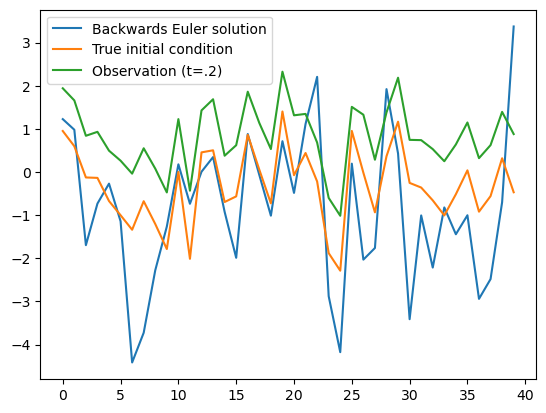

In [652]:
plt.plot(x[-1], label="Backwards Euler solution")
plt.plot(x0, label="True initial condition")
plt.plot(y, label="Observation (t=.2)")
plt.legend()

In [653]:
np.linalg.norm(x[-1] - x0)

9.25899472869773

## EKI

In [537]:
J = 50 # choose number of ensemble members
theta0 = np.random.randn(x0.shape[0], J) # generate initial ensemble of estimates

In [538]:
# map the theta0 ensemble through the numerical model 
# def forward_model(theta, noise=0.01):
#     theta_update = np.zeros_like(theta)
#     for i in range(J):
#         val_noise = np.random.randn(theta.shape[0]) * noise
#         theta_update[:,i] = solve_ivp(lorenz96, [0, n_steps*dt], theta[:,i], t_eval=np.arange(0.0, n_steps*dt, dt)).y.T[-1,:] + val_noise
#     return theta_update
def forward_model(theta):
    theta_update = np.zeros_like(theta)
    for i in range(J):
        theta_update[:,i] = solve_ivp(lorenz96, [0, n_steps*dt], theta[:,i], t_eval=np.arange(0.0, n_steps*dt, dt)).y.T[-1,:]
    return theta_update 

theta = forward_model(theta0)

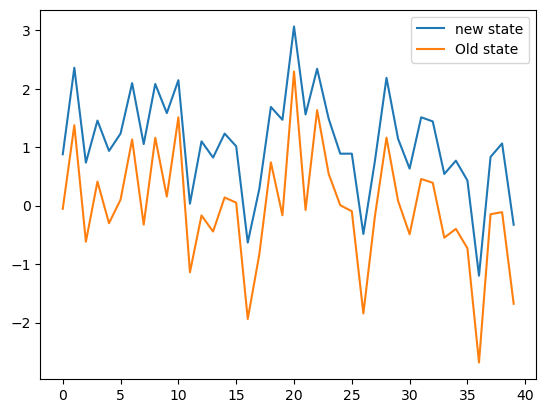

In [539]:
# example of what one forward model step looks like
plt.plot(theta[:,0], label = "new state")
plt.plot(theta0[:,0], label= "Old state")
plt.legend()

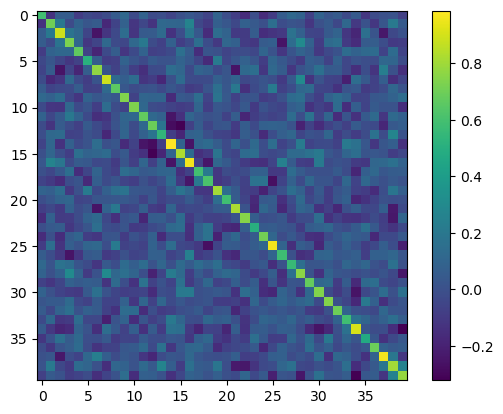

In [540]:

def CGG(Gtheta):
    return np.cov(Gtheta, bias=True)

def CTG(theta, Gtheta):
    """Calculate the cross covariance of the previous state and the next state. 
    Note that for early steps there won't be much correlation"""
    
    num_states = theta.shape[0]
    # https://stackoverflow.com/questions/45134122/numpy-cov-returns-unexpected-output
    return np.cov(np.transpose(theta), np.transpose(Gtheta), bias=True, rowvar=False)[:num_states, num_states:]

plt.imshow(CTG(forward_model(theta0), theta))
plt.colorbar()

In [541]:
# we then define our EKI update step
def EKI_update(theta, Gtheta, y, Gamma, J=J):
    """Update the ensemble of states using the EKI update formula"""
    update = CTG(theta, Gtheta) @ np.linalg.inv(Gamma + CGG(Gtheta)) @ (np.repeat(y, J).reshape(40, J) - Gtheta)
    
    return theta + update, np.linalg.norm(update)
#EKI_update(theta0, theta, y, np.eye(40) * 0.01)

In [542]:
# now we can run the EKI algorithm
iters = 10*40
next_theta = theta0
for i in range(iters):
    next_theta, norm = EKI_update(next_theta, forward_model(next_theta), y, np.eye(40) * .1)
    if i % 20 == 0:
        print(i, norm)
    if norm < 1e-4:
        print(i, norm)
        break

0 51.596170326761616
20 0.1463463825013526
40 0.06215012914205911
60 0.036488269654764934
80 0.024711353473751054
100 0.018158970906121324
120 0.014071318259671296
140 0.011320376125950772
160 0.009363063824915906
180 0.007911521907353794
200 0.006800189797941039
220 0.005927440242437013
240 0.005226941773689173
260 0.004654391306961081
280 0.004179540596386983
300 0.0037807510476826765
320 0.0034409286367422763
340 0.0031488659002162733
360 0.002896313015773915
380 0.002675837494641279


In [543]:
print(np.linalg.norm(theta0.mean(axis=1) - x0))
np.linalg.norm(next_theta.mean(axis=1) - x0)

6.016941273595244


0.2757407540098839

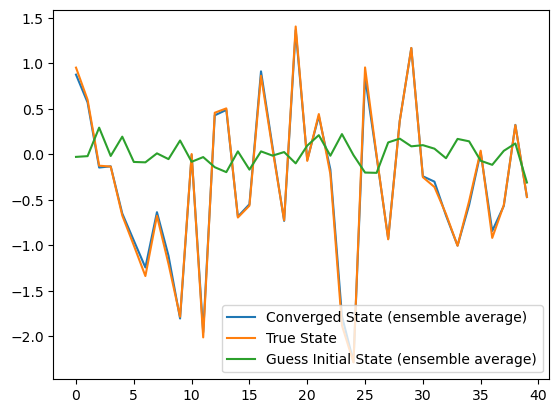

In [544]:
plt.plot(next_theta.mean(axis=1), label="Converged State (ensemble average)")
plt.plot(x0,label="True State")
plt.plot(theta0.mean(axis=1), label="Guess Initial State (ensemble average)")
plt.legend()

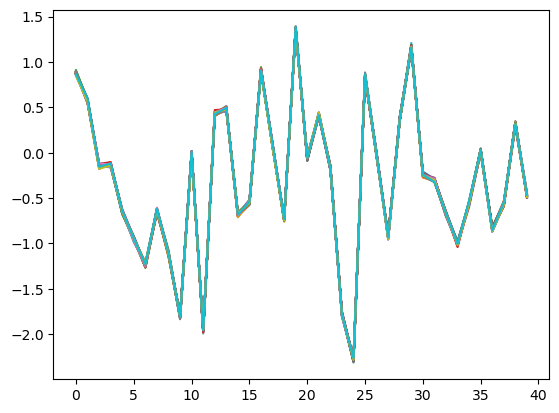

In [545]:
plt.plot(next_theta);

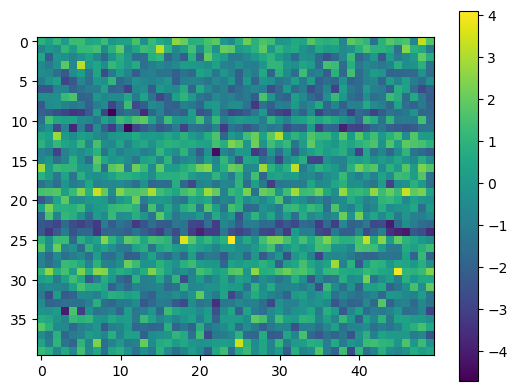

In [546]:
plt.imshow(next_theta-theta0)
plt.colorbar()

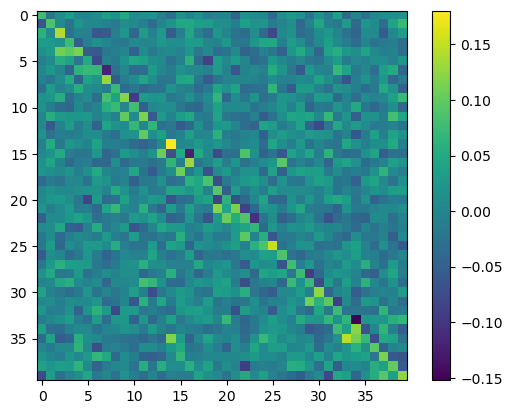

In [547]:
plt.imshow(CTG(theta0, theta) -CGG(theta))
plt.colorbar()

## MCMC 
We are asked to draw samples from the posterior using MCMC. A general posterior looks like:
$$ \pi^y(u) = \frac{1}{Z} \nu(y-\mathcal{G}(u))\rho(u) $$
In our setting the posterior, $\pi^y(u)$, is the posterior of the \textit{initial} condition given an observation, $$\nu(y-\mathcal{G}(u)) \propto \exp\left(-\frac{1}{2}|y-\mathcal{G}(u)|_\Gamma^2 \right)$$ is the likihood function of the initial condition given the observations, $y$, and $\rho(u)$ is the multivariate normal prior we set for the initial condition (which is the same as what the true distribution was drawn from). To implement this we will use the Metropolis-Hastings Algorithm with the following distributions:
Initial sample:
$$ u^{(0)} \sim \pi_0; \;\;\; \pi_0 = \mathcal{MVN}(\vec{0}, I_{40})$$
(Note we could use $\pi_0=\mathcal{MVN}(\text{mean converged EKI}, \text{cov converged EKI})$ if current proposal fails to converge)
$$v^\star \sim q(u^{(n)},v) = \mathcal{MVN}(u^{(n)}-v, \mathbb{I}_{40}) \propto \exp \left[-\frac{1}{2} (u^{(n)}-v)^T\mathbb{I}_{40}(u^{(n)}-v)\right]$$ 

### Uninformed Prior
This ended up not being successful because the acceptance probabilities were too low starting far from the true solution. 

In [551]:
def G(u):
    """Forward model for the Lorenz96 system."""
    return solve_ivp(lorenz96, [0, n_steps*dt], u, t_eval=np.arange(0.0, n_steps*dt, dt)).y.T[-1,:]

def propnu(u, y=y, noise=0.1):
    return np.exp(-0.5 * np.transpose(y - G(u)) @ (np.eye(40) * noise) @ np.linalg.inv(np.eye(40) * noise) @ (y - G(u)))

def q(u):
    return np.random.multivariate_normal(u, np.eye(40))

def propq(u,v):
    return np.exp(-0.5 * np.transpose(u - v) @ np.linalg.inv(np.eye(40)) @ (u - v))

def proprho(u):
    return np.exp(-0.5 * np.transpose(u) @ np.linalg.inv(np.eye(40)) @ u)

def a(u, v):
    return min(1, propnu(v, y) * propq(v,u) * proprho(v) / \
               (propnu(u, y) * propq(u,v) * proprho(u)))

#a(theta0[:,0], theta0[:,9])

In [552]:
# with our functions defined we can now run the MCMC algorithm
n_samples = 10000
samples = np.zeros((n_samples, 40))
samples[0] = theta0[:,0] # random initial guess (just reusing from before)
probs = np.zeros(n_samples)
for i in range(1, n_samples):
    u = samples[i-1]
    v = q(u)
    accept_prob = a(u, v)
    probs[i] = accept_prob
    if np.random.rand() < accept_prob:
        print("Accepted!")
        samples[i] = v
    else:
        samples[i] = u

Accepted!
Accepted!
Accepted!
Accepted!
Accepted!


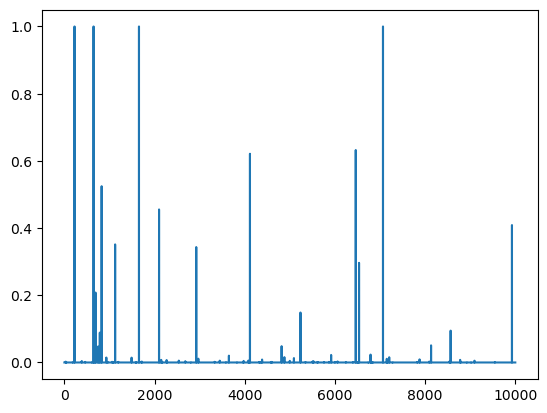

In [553]:
plt.plot(probs)

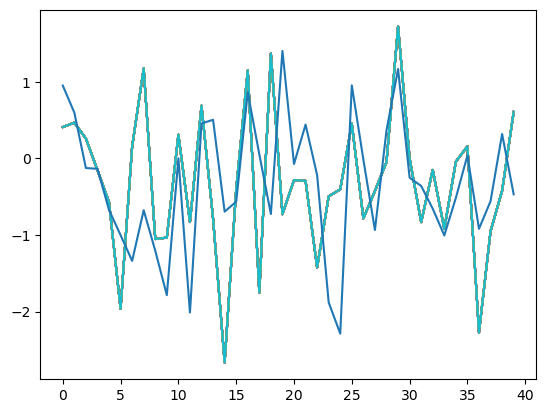

In [554]:
plt.plot(np.transpose(samples[9980:,]))
plt.plot(x0)

## Let's inform our MCMC with the results from the EKI
Use the mean and covariance from final eki result (maybe we'll need to scale up the covariance matrix so it doesn't collapse). These will become both our initial distribution and inform the sampler variance \texttt{q(u)}

In [555]:
# calculate the mean and covariance matrix of EKI result 
mean_eki = next_theta.mean(axis=1)
cov_eki = np.cov(next_theta, bias=True)
np.linalg.cond(cov_eki) # well conditioned

2.6229545885692365

Text(0.5, 1.0, 'Scaled EKI Coviariance Matrix')

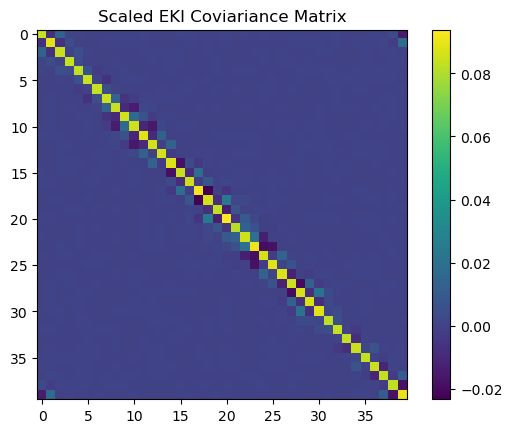

In [556]:
plt.imshow(cov_eki * 500) # cool to see that only local correlations exist
plt.colorbar()
plt.title("Scaled EKI Coviariance Matrix")

In [557]:
# update q(u) to use the covariance matrix of the EKI result
scale = 500
def q(u):
    return np.random.multivariate_normal(u, cov_eki * scale)
print(f"Matrix Norm: {np.linalg.norm(cov_eki * scale)}")


# with our functions defined we can now run the MCMC algorithm
n_samples = 1000
samples = np.zeros((n_samples, 40))

# update initial guess to use the mean of the eki result 
samples[0] = mean_eki

# run Metropolis Hastings
probs, accepted = np.zeros(n_samples), np.zeros(n_samples)
for i in range(1, n_samples):
    u = samples[i-1]
    v = q(u)
    accept_prob = a(u, v)
    probs[i] = accept_prob
    if np.random.rand() < accept_prob:
        accepted[i] = 1
        samples[i] = v
    else:
        samples[i] = u
print(f"Acceptance rate: {accepted.mean()}")

Matrix Norm: 0.5580548320035345


Acceptance rate: 0.222


Text(0.5, 1.0, 'EKI Informed MCMC Sampling of Lorenz96 System (cov-upweighting by 100)')

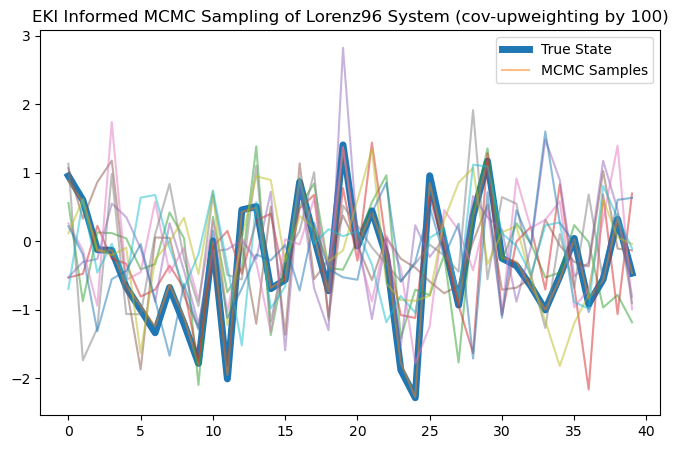

In [558]:
plt.figure(figsize=(8,5))
plt.plot(x0, linewidth=5)
plt.plot(np.transpose(samples[::100]), alpha=.5) # get every 1000th sample to reduce correlation
plt.legend(["True State", "MCMC Samples"])
plt.title("EKI Informed MCMC Sampling of Lorenz96 System (cov-upweighting by 100)")

### Correlation Assessment
Assess how frequently we should subsample by looking at the correlation

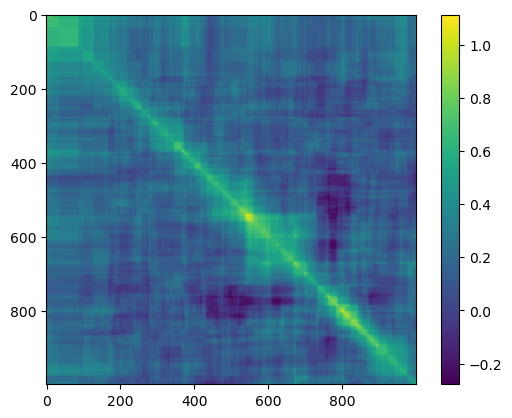

In [417]:
plt.imshow(np.cov(samples))
plt.colorbar()

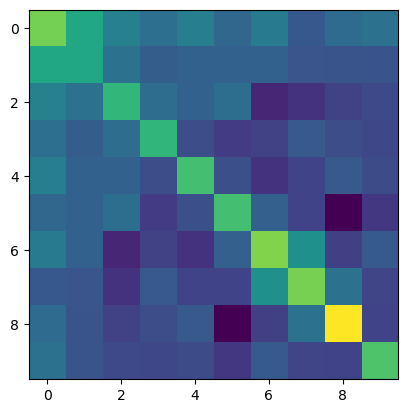

In [418]:
plt.imshow(np.cov(samples[::100]))

In [423]:
np.correlate(samples[:,0], samples[:,0])

array([462.72653102])

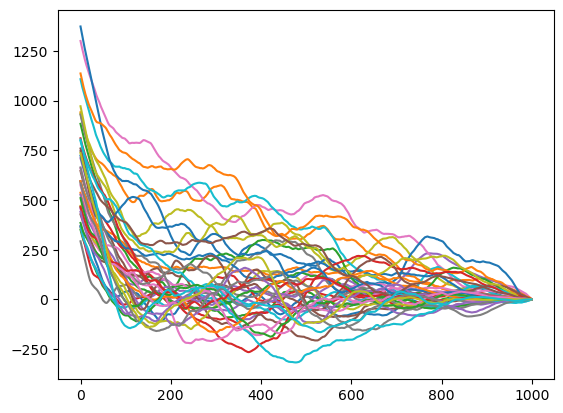

In [430]:
ndim = 1
for i in range(40):
    plt.plot(np.correlate(samples[:,i], samples[:,i], mode='full')[-n_samples:])


In [431]:
def autocorrelation(x):
    """Calculate the autocorrelation of the time series x."""
    n = len(x)
    variance = np.var(x)
    x = x - np.mean(x)
    r = np.correlate(x, x, mode='full')[-n:]
    result = r / (variance * (np.arange(n, 0, -1)))
    return result

def integrated_autocorrelation_time(autocorr):
    """Calculate the integrated autocorrelation time from the autocorrelation function."""
    return 1 + 2 * np.sum(autocorr[1:])

def autocorrelation_time(samples):
    """Calculate the autocorrelation time for each dimension in the MCMC samples."""
    n_samples, n_dim = samples.shape
    autocorr_times = np.zeros(n_dim)
    
    for d in range(n_dim):
        autocorr = autocorrelation(samples[:, d])
        # Truncate the autocorrelation function where it first becomes negative
        autocorr = autocorr[autocorr > 0]
        autocorr_times[d] = integrated_autocorrelation_time(autocorr)
        
    return autocorr_times

# Calculate autocorrelation times for each dimension
autocorr_times = autocorrelation_time(samples)

# Print the autocorrelation times
print("Autocorrelation times for each dimension:", autocorr_times)

# Average autocorrelation time over all dimensions
average_autocorr_time = np.mean(autocorr_times)
print("Average autocorrelation time:", average_autocorr_time)


Autocorrelation times for each dimension: [370.07855665 250.05569537 173.90808    153.90714533 428.41948706
 173.70439641 318.71685082 110.37948198 292.9368604  124.2217306
 204.23039939 136.43548011 275.77017341 181.98212452 171.42438696
 436.20115754 218.81365299 198.90343711 351.45190176 487.11179756
 122.90389443 163.94092006 270.30624    339.55680468 212.82669166
 283.86904527 293.33236266 144.35986332 190.06953387 253.28395244
 190.85854507 173.81648115 188.79121215 188.96017021 245.78114555
 195.81640344 175.09072243 204.72838489 225.82342265 153.8556337 ]
Average autocorrelation time: 231.91560563996853


## Update EKI observation map for partial observations

In [560]:
# generate observations 
t_tot = .2
n_steps = 4
dt = t_tot / n_steps

# Generate a random state
np.random.seed(270)
x0 = np.random.randn(40)

x = x0
x_ml = np.zeros((n_steps, 40))
x_ml[0] = x0
for i in range(1, n_steps):
    x = nn._smodel.predict(x.reshape((1, 40, 1)))[0, :, 0]
    x_ml[i] = x

x_phys = solve_ivp(lorenz96, [0, n_steps*dt], x0, t_eval=np.arange(0.0, n_steps*dt, dt)).y.T

y = x_phys[-1,:] # extract values we want to fit with EKI
y_ml = x_ml[-1,:]

In [561]:
# partial observations, these are what we get to tune our model to
def H(y, it=2):
    return y[::it]

y_obs = H(y)
y_ml_obs = H(y_ml)

In [562]:
# as before our samples are drawn from a 40-dimensional initial condition
J = 50 # choose number of ensemble members
theta0 = np.random.randn(x0.shape[0], J) # generate initial ensemble of estimates

def forward_model(theta, observation_map = H):
    """Lorenz 96 Forward Model"""
    theta_update = np.zeros_like(theta)
    for i in range(J):
        theta_update[:,i] = solve_ivp(lorenz96, [0, n_steps*dt], theta[:,i], t_eval=np.arange(0.0, n_steps*dt, dt)).y.T[-1,:]
    # note that this time we apply the observation map to the output
    return observation_map(theta_update)

def CGG(Gtheta):
    """Returns the covariance matrix of the forward ensemble states"""
    return np.cov(Gtheta, bias=True)

def CTG(theta, Gtheta):
    """Calculate the cross covariance of the previous state and the next state. 
    Note that for early steps there won't be much correlation"""
    
    first_dim, second_dim = theta.shape[0], Gtheta.shape[0]
    # https://stackoverflow.com/questions/45134122/numpy-cov-returns-unexpected-output
    return np.cov(np.transpose(theta), np.transpose(Gtheta), bias=True, rowvar=False)[:first_dim, -second_dim:]

def EKI_update(theta, Gtheta, y, Gamma, J=J):
    """Update the ensemble of states using the EKI update formula"""
    update = CTG(theta, Gtheta) @ np.linalg.inv(Gamma + CGG(Gtheta)) @ (np.repeat(y, J).reshape(y.shape[0], J) - Gtheta)
    
    return theta + update, np.linalg.norm(update)

In [563]:
max_iter = 10*40
next_theta = theta0
for i in range(max_iter):
    next_theta, norm = EKI_update(next_theta, forward_model(next_theta), y_obs, np.eye(y_obs.shape[0]) * 1)
    if i % 20 == 0:
        print(i, norm)
    if norm < 1e-2:
        print(i, norm)
        break

0 21.984531745302363
20 0.3092056445381983
40 0.13831934947689012
60 0.09228067073791478
80 0.07321149077797583
100 0.06365960122064292
120 0.05840702817868888
140 0.05530031438514131
160 0.05337601837394176
180 0.05204959386014684
200 0.05099969289343354
220 0.04992034706047525
240 0.048695250577539644
260 0.04722621832034701
280 0.045479719990717975
300 0.043527365630900657
320 0.041427275597221785
340 0.039277547061275814
360 0.03715307949031956
380 0.03511096282316036


In [564]:
print(np.linalg.norm(theta0.mean(axis=1) - x0))
np.linalg.norm(next_theta.mean(axis=1) - x0)

6.016941273595244


6.091880006752777

In [571]:
theta0[::2].shape

(20, 50)

In [573]:
# does converge well on the locations we show EKI!
print(np.linalg.norm(theta0[::2].mean(axis=1) - x0[::2]))
np.linalg.norm(next_theta[::2].mean(axis=1) - x0[::2])

3.722818358140986


0.6973337241857684

Text(0.5, 1.0, 'EKI Convergence for Partial Observations')

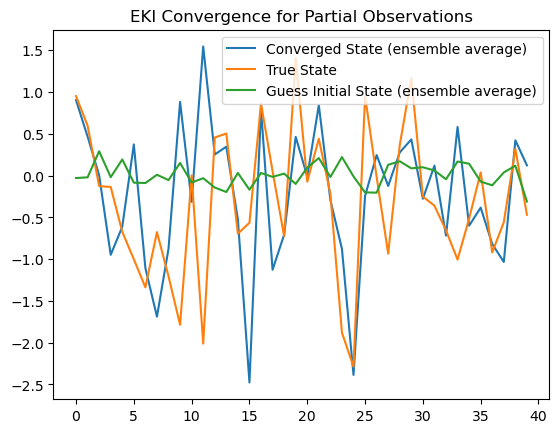

In [566]:
plt.plot(next_theta.mean(axis=1), label="Converged State (ensemble average)")
plt.plot(x0,label="True State")
plt.plot(theta0.mean(axis=1), label="Guess Initial State (ensemble average)")
plt.legend()
plt.title("EKI Convergence for Partial Observations")

### Sample from the posterior using MCMC
Again, we'll use the results from the EKI model

In [574]:
mean_eki = next_theta.mean(axis=1)
cov_eki = np.cov(next_theta, bias=True)

Text(0.5, 1.0, 'EKI Coviariance Matrix')

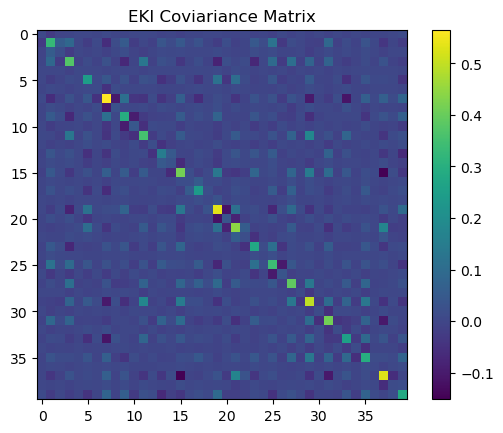

In [575]:
plt.imshow(cov_eki ) # much stranger covariance matrix!
plt.colorbar()
plt.title("EKI Coviariance Matrix")

In [576]:
def G(u, observation_map = H):
    """Forward model for the Lorenz96 system."""
    return observation_map(solve_ivp(lorenz96, [0, n_steps*dt], u, t_eval=np.arange(0.0, n_steps*dt, dt)).y.T[-1,:])

def propnu(u, y=y, noise=0.1):
    return np.exp(-0.5 * np.transpose(y - G(u)) @ (np.eye(y.shape[0]) * noise) @ np.linalg.inv(np.eye(y.shape[0]) * noise) @ (y - G(u)))

def q(u, cov_eki=cov_eki, scale=500):
    """use the covariance matrix of the EKI result to generate a new proposal"""
    return np.random.multivariate_normal(u, cov_eki * scale)

def propq(u,v, y=y):
    return np.exp(-0.5 * np.transpose(u - v) @ np.linalg.inv(np.eye(40)) @ (u - v))

def proprho(u,y=y):
    return np.exp(-0.5 * np.transpose(u) @ np.linalg.inv(np.eye(40)) @ u)

def a(u, v, y=y):
    return min(1, propnu(v, y) * propq(v, u, y) * proprho(v, y) / \
               (propnu(u, y) * propq(u, v, y) * proprho(u, y)))

In [577]:
tu = mean_eki
tv =q(tu)
propnu(tu, y_obs)
proprho(tu, y_obs)
a(tu, tv, y_obs)

/var/folders/4d/j6w5sd4514x02scwb1gkq_900000gn/T/ipykernel_17432/1179860384.py:19: RuntimeWarning: invalid value encountered in scalar divide
  return min(1, propnu(v, y) * propq(v, u, y) * proprho(v, y) / \


1

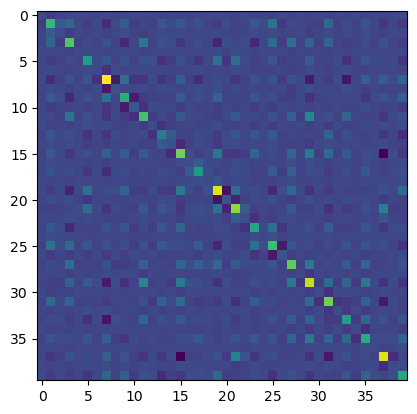

In [578]:
plt.imshow(cov_eki) # high 

In [580]:
np.linalg.cond(cov_eki) # very high condition number - we'll use a scaled identity matrix as covariance instead

3143.7503911758386

In [581]:
# with our functions defined we can now run the MCMC algorithm
n_samples = 1000
samples = np.zeros((n_samples, 40))

# update initial guess to use the mean of the eki result 
samples[0] = mean_eki

# run Metropolis Hastings
probs, accepted = np.zeros(n_samples), np.zeros(n_samples)
for i in range(1, n_samples):
    u = samples[i-1]
    # I tuned the chain acceptance probability by adjusting the covariance matrix
    v = q(u, np.eye(40)*.1, scale=1) 
    accept_prob = a(u, v, y_obs)
    probs[i] = accept_prob
    #print(accept_prob)
    if np.random.rand() < accept_prob:
        accepted[i] = 1
        samples[i] = v
    else:
        samples[i] = u
print(f"Acceptance rate: {accepted.mean()}")

Acceptance rate: 0.265


Text(0.5, 1.0, 'EKI Informed MCMC Sampling of Lorenz96 System with Partial Observations')

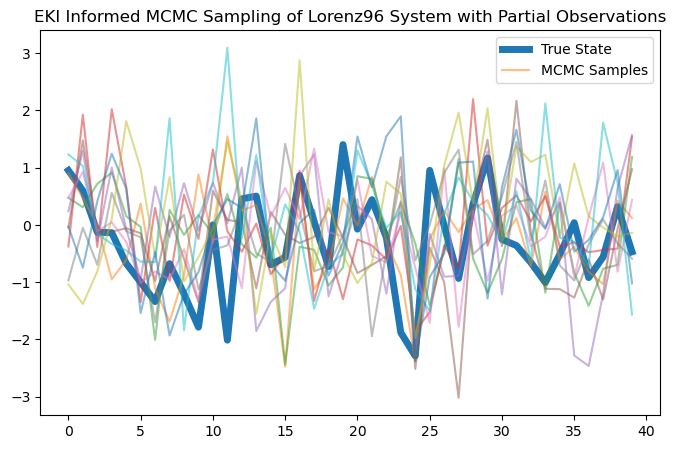

In [582]:
# visualize samples
plt.figure(figsize=(8,5))
plt.plot(x0, linewidth=5)
plt.plot(np.transpose(samples[::100]), alpha=.5) # get every 1000th sample to reduce correlation
plt.legend(["True State", "MCMC Samples"])
plt.title("EKI Informed MCMC Sampling of Lorenz96 System with Partial Observations")

## Repeat with the ML Model